In [1]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imwrite
from scipy.stats import zscore

2026-02-13 15:40:15.345159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770997215.534049      25 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770997215.584920      25 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770997216.023945      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770997216.024004      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770997216.024007      25 computation_placer.cc:177] computation placer alr

In [2]:
# !rm -rf checkpoints
# !mkdir checkpoints


In [3]:
#load the complete volume of the image.

import os
import numpy as np
import random
import nibabel as nib
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from scipy.ndimage import zoom


# -----------------------------
# Load NIfTI file and convert to NumPy array
# -----------------------------
def load_nii(path, is_mask=False):
    nii = nib.load(path)
    arr = np.array(nii.get_fdata(), dtype=np.float32)  # Convert to float32
    if is_mask:
        arr = arr.astype(np.int32)  # Masks as integers
    return arr



# -----------------------------
# Data Generator
# -----------------------------
def imageLoader_full(root_dir, patient_list, batch_size):

    L = len(patient_list)
    indices = np.arange(L)

    while True:
        indices = shuffle(indices, random_state=None)

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            batch_indices = indices[batch_start:limit]

            X_t1, X_t1ce, X_t2, X_flair, Y = [], [], [], [], []

            for i in batch_indices:
                patient_id = patient_list[i]
                patient_path = os.path.join(root_dir, patient_id)

                files_needed = [
                    f"{patient_id}-t1n.nii",
                    f"{patient_id}-t1c.nii",
                    f"{patient_id}-t2w.nii",
                    f"{patient_id}-t2f.nii",
                    f"{patient_id}-seg.nii"
                ]

                files_exist = all(os.path.exists(os.path.join(patient_path, f)) for f in files_needed)
                if not files_exist:
                    print(f"Skipping {patient_id} due to missing files.")
                    continue

                # Load and resize modalities
                t1 = load_nii(os.path.join(patient_path, f"{patient_id}-t1n.nii"))
                t1ce = load_nii(os.path.join(patient_path, f"{patient_id}-t1c.nii"))
                t2 = load_nii(os.path.join(patient_path, f"{patient_id}-t2w.nii"))
                flair =load_nii(os.path.join(patient_path, f"{patient_id}-t2f.nii"))
                mask = load_nii(os.path.join(patient_path, f"{patient_id}-seg.nii"), is_mask=True)

                # Append to batch
                X_t1.append(t1)
                X_t1ce.append(t1ce)
                X_t2.append(t2)
                X_flair.append(flair)
                Y.append(mask)

            if len(X_t1) == 0:
                batch_start += batch_size
                batch_end += batch_size
                continue

            # Convert lists to NumPy arrays explicitly
            X_t1 = np.array(X_t1, dtype=np.float32)
            X_t1ce = np.array(X_t1ce, dtype=np.float32)
            X_t2 = np.array(X_t2, dtype=np.float32)
            X_flair = np.array(X_flair, dtype=np.float32)
            Y = np.array(Y, dtype=np.int32)

            # -------- Normalization --------
            X_t1 = (X_t1 - np.mean(X_t1)) / np.std(X_t1)
            X_t1ce = (X_t1ce - np.mean(X_t1ce)) / np.std(X_t1ce)
            X_t2 = (X_t2 - np.mean(X_t2)) / np.std(X_t2)
            X_flair = (X_flair - np.mean(X_flair)) / np.std(X_flair)

            # -------- Stack modalities --------
            X = np.stack([X_t1, X_t1ce, X_t2, X_flair], axis=4)

            # -------- One-hot encode masks (4 classes) --------
            Y[Y > 3] = 3
            Y = to_categorical(Y, num_classes=4)

            yield (X, Y)

            batch_start += batch_size
            batch_end += batch_size


# -----------------------------
# Paths & Dataset
# -----------------------------
root_dir_full = '/kaggle/input/brats-2024-dataset/zip data'
patient_list_full = sorted(os.listdir(root_dir_full))

batch_size_full = 1

train_img_full = imageLoader_full(
    root_dir=root_dir_full,
    patient_list=patient_list_full,
    batch_size=batch_size_full,
)


img_full, msk_full = train_img_full.__next__()
test_img_full = img_full[0]
test_mask_full = msk_full[0]

print("Image shape:", test_img_full.shape)
print("Mask shape:", test_mask_full.shape)


Image shape: (182, 218, 182, 4)
Mask shape: (182, 218, 182, 4)


In [4]:
#Load the centered crop image of  (H, W , D) (128, 165, 128)

import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical


# -----------------------------
# Load NIfTI file
# -----------------------------
def load_nii(path, is_mask=False):
    nii = nib.load(path)
    arr = np.array(nii.get_fdata(), dtype=np.float32)

    if is_mask:
        arr = arr.astype(np.int32)

    return arr


# -----------------------------
# Compute Brain Bounding Box from FLAIR
# -----------------------------
def get_brain_bbox(volume, margin=8):

    non_zero = np.argwhere(volume > 0)

    if len(non_zero) == 0:
        # fallback to full image
        return (0, volume.shape[0],
                0, volume.shape[1],
                0, volume.shape[2])

    min_coords = non_zero.min(axis=0)
    max_coords = non_zero.max(axis=0)

    min_coords = np.maximum(min_coords - margin, 0)
    max_coords = np.minimum(max_coords + margin, np.array(volume.shape) - 1)

    return (min_coords[0], max_coords[0] + 1,
            min_coords[1], max_coords[1] + 1,
            min_coords[2], max_coords[2] + 1)


# -----------------------------
# Crop using bounding box
# -----------------------------
def crop_with_bbox(volume, bbox):
    d1, d2, h1, h2, w1, w2 = bbox
    return volume[d1:d2, h1:h2, w1:w2]


# -----------------------------
# Final Center Crop to 128³ (with padding)
# -----------------------------
# -----------------------------
# Final Crop preserving AP axis
# -----------------------------
def final_safe_crop(volume, target_shape=(128, 176, 128)):

    td, th, tw = target_shape
    d, h, w = volume.shape

    # -------- Preserve depth as much as possible --------
    # Only trim if depth is larger than target
    if d > td:
        extra = d - td
        start_d = extra // 2
        volume = volume[start_d:start_d + td, :, :]
    elif d < td:
        pad_d = td - d
        volume = np.pad(
            volume,
            ((pad_d // 2, pad_d - pad_d // 2), (0, 0), (0, 0)),
            mode='constant'
        )

    # -------- Center crop H & W --------
    d, h, w = volume.shape

    if h > th:
        start_h = (h - th) // 2
        volume = volume[:, start_h:start_h + th, :]
    elif h < th:
        pad_h = th - h
        volume = np.pad(
            volume,
            ((0, 0), (pad_h // 2, pad_h - pad_h // 2), (0, 0)),
            mode='constant'
        )

    d, h, w = volume.shape

    if w > tw:
        start_w = (w - tw) // 2
        volume = volume[:, :, start_w:start_w + tw]
    elif w < tw:
        pad_w = tw - w
        volume = np.pad(
            volume,
            ((0, 0), (0, 0), (pad_w // 2, pad_w - pad_w // 2)),
            mode='constant'
        )

    return volume



# -----------------------------
# Data Generator
# -----------------------------
def imageLoader(root_dir, patient_list, batch_size):

    L = len(patient_list)
    indices = np.arange(L)

    while True:
        indices = shuffle(indices)

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:

            limit = min(batch_end, L)
            batch_indices = indices[batch_start:limit]

            X_batch = []
            Y_batch = []

            for i in batch_indices:

                patient_id = patient_list[i]
                patient_path = os.path.join(root_dir, patient_id)

                files_needed = [
                    f"{patient_id}-t1n.nii",
                    f"{patient_id}-t1c.nii",
                    f"{patient_id}-t2w.nii",
                    f"{patient_id}-t2f.nii",
                    f"{patient_id}-seg.nii"
                ]

                if not all(os.path.exists(os.path.join(patient_path, f)) for f in files_needed):
                    print(f"Skipping {patient_id} due to missing files.")
                    continue

                # -------- Load volumes --------
                t1 = load_nii(os.path.join(patient_path, f"{patient_id}-t1n.nii"))
                t1ce = load_nii(os.path.join(patient_path, f"{patient_id}-t1c.nii"))
                t2 = load_nii(os.path.join(patient_path, f"{patient_id}-t2w.nii"))
                flair = load_nii(os.path.join(patient_path, f"{patient_id}-t2f.nii"))
                mask = load_nii(os.path.join(patient_path, f"{patient_id}-seg.nii"), is_mask=True)

                # -------- Compute brain bbox from FLAIR --------
                bbox = get_brain_bbox(flair, margin=8)

                # -------- Crop all modalities using SAME bbox --------
                t1 = crop_with_bbox(t1, bbox)
                t1ce = crop_with_bbox(t1ce, bbox)
                t2 = crop_with_bbox(t2, bbox)
                flair = crop_with_bbox(flair, bbox)
                mask = crop_with_bbox(mask, bbox)

                # -------- Final center crop to 128³ --------
                t1 = final_safe_crop(t1)
                t1ce = final_safe_crop(t1ce)
                t2 = final_safe_crop(t2)
                flair = final_safe_crop(flair)
                mask = final_safe_crop(mask)

                # -------- Normalize per volume (better than per batch) --------
                def normalize(x):
                    return (x - np.mean(x)) / (np.std(x) + 1e-8)

                t1 = normalize(t1)
                t1ce = normalize(t1ce)
                t2 = normalize(t2)
                flair = normalize(flair)

                # -------- Stack modalities --------
                X = np.stack([t1, t1ce, t2, flair], axis=-1)

                # -------- Prepare mask --------
                mask[mask > 3] = 3
                mask = to_categorical(mask, num_classes=4)

                X_batch.append(X)
                Y_batch.append(mask)

            if len(X_batch) == 0:
                batch_start += batch_size
                batch_end += batch_size
                continue

            X_batch = np.array(X_batch, dtype=np.float32)
            Y_batch = np.array(Y_batch, dtype=np.float32)

            yield (X_batch, Y_batch)

            batch_start += batch_size
            batch_end += batch_size


# -----------------------------
# Dataset Paths
# -----------------------------
root_dir = '/kaggle/input/brats-2024-dataset/zip data'
patient_list = sorted(os.listdir(root_dir))

batch_size = 2

train_img = imageLoader(
    root_dir=root_dir,
    patient_list=patient_list,
    batch_size=batch_size,
)


img, msk = train_img.__next__()
test_img = img[0]
test_mask = msk[0]

print("Image shape:", test_img.shape)
print("Mask shape:", test_mask.shape)

Image shape: (128, 176, 128, 4)
Mask shape: (128, 176, 128, 4)


In [5]:
# #Code, that loads the image in patches. 

# import os
# import numpy as np
# import random
# import nibabel as nib
# import tensorflow as tf
# from sklearn.utils import shuffle
# from tensorflow.keras.utils import to_categorical
# from matplotlib import pyplot as plt
# from scipy.ndimage import zoom


# # -----------------------------
# # Load NIfTI file and convert to NumPy array
# # -----------------------------
# def load_nii(path, is_mask=False):
#     nii = nib.load(path)
#     arr = np.array(nii.get_fdata(), dtype=np.float32)
#     if is_mask:
#         arr = arr.astype(np.int32)
#     return arr


# # -----------------------------
# # Resize volume to (128,128,128)
# # -----------------------------
# def resize_volume(volume, target_shape=(128, 128, 128), is_mask=False):
#     factors = (
#         target_shape[0] / volume.shape[0],
#         target_shape[1] / volume.shape[1],
#         target_shape[2] / volume.shape[2],
#     )
#     order = 0 if is_mask else 1
#     return zoom(volume, factors, order=order)


# # -----------------------------
# # Data Generator (PATCHED + OVERLAP)
# # -----------------------------
# def imageLoader(root_dir, patient_list, batch_size,
#                 patch_size=(64, 64, 64),
#                 tiles_per_patient=5,
#                 overlap=0.5):

#     L = len(patient_list)
#     indices = np.arange(L)

#     while True:
#         indices = shuffle(indices)

#         X_batch, Y_batch = [], []

#         for i in indices:
#             patient_id = patient_list[i]
#             patient_path = os.path.join(root_dir, patient_id)

#             files_needed = [
#                 f"{patient_id}-t1n.nii",
#                 f"{patient_id}-t1c.nii",
#                 f"{patient_id}-t2w.nii",
#                 f"{patient_id}-t2f.nii",
#                 f"{patient_id}-seg.nii"
#             ]

#             if not all(os.path.exists(os.path.join(patient_path, f)) for f in files_needed):
#                 print(f"Skipping {patient_id} due to missing files.")
#                 continue

#             # -------- Load & resize --------
#             t1 = resize_volume(load_nii(os.path.join(patient_path, f"{patient_id}-t1n.nii")))
#             t1ce = resize_volume(load_nii(os.path.join(patient_path, f"{patient_id}-t1c.nii")))
#             t2 = resize_volume(load_nii(os.path.join(patient_path, f"{patient_id}-t2w.nii")))
#             flair = resize_volume(load_nii(os.path.join(patient_path, f"{patient_id}-t2f.nii")))
#             mask = resize_volume(
#                 load_nii(os.path.join(patient_path, f"{patient_id}-seg.nii"), is_mask=True),
#                 is_mask=True
#             )

#             # -------- Normalize --------
#             t1 = (t1 - np.mean(t1)) / np.std(t1)
#             t1ce = (t1ce - np.mean(t1ce)) / np.std(t1ce)
#             t2 = (t2 - np.mean(t2)) / np.std(t2)
#             flair = (flair - np.mean(flair)) / np.std(flair)

#             # -------- Stack modalities --------
#             X_vol = np.stack([t1, t1ce, t2, flair], axis=-1)

#             # -------- One-hot encode mask --------
#             mask[mask > 3] = 3
#             Y_vol = to_categorical(mask, num_classes=4)

#             # -------- Overlapping patches --------
#             d, h, w, _ = X_vol.shape
#             dz = int(patch_size[0] * (1 - overlap))
#             dy = int(patch_size[1] * (1 - overlap))
#             dx = int(patch_size[2] * (1 - overlap))

#             z_starts = list(range(0, d - patch_size[0] + 1, dz))
#             y_starts = list(range(0, h - patch_size[1] + 1, dy))
#             x_starts = list(range(0, w - patch_size[2] + 1, dx))

#             all_patches = []
#             for z in z_starts:
#                 for y in y_starts:
#                     for x in x_starts:
#                         px = X_vol[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2], :]
#                         py = Y_vol[z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2], :]
#                         all_patches.append((px, py))

#             # -------- Limit tiles per patient --------
#             selected_patches = random.sample(
#                 all_patches,
#                 min(tiles_per_patient, len(all_patches))
#             )

#             for px, py in selected_patches:
#                 X_batch.append(px)
#                 Y_batch.append(py)

#                 if len(X_batch) == batch_size:
#                     yield (
#                         np.array(X_batch, dtype=np.float32),
#                         np.array(Y_batch, dtype=np.float32)
#                     )
#                     X_batch, Y_batch = [], []


# # -----------------------------
# # Paths & Dataset
# # -----------------------------
# root_dir = '/kaggle/input/brats-2024-dataset/zip data'
# patient_list = sorted(os.listdir(root_dir))

# batch_size = 2  # patches per batch

# train_img_datagen = imageLoader(
#     root_dir=root_dir,
#     patient_list=patient_list,
#     batch_size=batch_size,
#     patch_size=(128, 128, 128),
#     tiles_per_patient=5,
#     overlap=0.5
# )


In [6]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
#from keras.layers.normalization import InstanceNormalization
from keras.optimizers import SGD
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want

# Function to implement instance normalization
def instance_normalization(x):
    # Calculate mean and variance along the spatial dimensions
    mean, var = tf.nn.moments(x, axes=[1, 2, 3], keepdims=True)
    
    # Perform instance normalization
    epsilon = 1e-5
    x = (x - mean) / tf.sqrt(var + epsilon)
    
    return x
################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #output_shape=lambda s: s

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    #c1 = Dropout(0.2)(c1)
    c1 = Lambda(instance_normalization)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Lambda(instance_normalization)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.3)(c3)
    c3 = Lambda(instance_normalization)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.4)(c4)
    c4 = Lambda(instance_normalization)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.5)(c5)
    c5 = Lambda(instance_normalization)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.4)(c6)
    c6 = Lambda(instance_normalization)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.3)(c7)
    c7 = Lambda(instance_normalization)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Lambda(instance_normalization)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Lambda(instance_normalization)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 176, 128, 4, 4)
print(model.input_shape)
print(model.output_shape)


I0000 00:00:1770997239.980826      25 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 176,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 176,  │      1,744 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 176,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 176,  │      6,928 │ lambda[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 88,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 88,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 88,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64, 88,    │          0 │ dropout[0][0]     │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 88,    │     27,680 │ lambda_1[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 44,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 44,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 44,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 32, 44,    │          0 │ dropout_1[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 44,    │    110,656 │ lambda_2[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 22,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 22,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 22,    │          0 │ conv3d_6[0][0]  

 Total params: 5,646,260 (21.54 MB)

 Trainable params: 5,646,260 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 176, 128, 4)
(None, 128, 176, 128, 4)


In [7]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# -----------------------------
# Dataset root
# -----------------------------
root_dir = "/kaggle/input/brats-2024-dataset/zip data"  # your single root folder

# Get all patient folders
all_patients = sorted(os.listdir(root_dir))

# Split into train and validation (e.g., 80% train, 20% val)
train_patient_list, val_patient_list = train_test_split(
    all_patients, test_size=0.2, random_state=42
)


print(f"Total patients: {len(all_patients)}")
print(f"Training patients: {len(train_patient_list)}")
print(f"Validation patients: {len(val_patient_list)}")

batch_size = 2

# -----------------------------
# Data generators
# -----------------------------


train_img_datagen = imageLoader(
    root_dir=root_dir,
    patient_list=train_patient_list,
    batch_size=batch_size,
)

val_img_datagen = imageLoader(
    root_dir=root_dir,
    patient_list=val_patient_list,
    batch_size=batch_size,
)

# -----------------------------
# Verify training generator
# -----------------------------
img, msk = train_img_datagen.__next__()

img_num = random.randint(0, img.shape[0] - 1)
test_img = img[img_num]
test_mask = msk[img_num]

print("Image shape:", test_img.shape)
print("Mask shape:", test_mask.shape)


Total patients: 262
Training patients: 209
Validation patients: 53
Image shape: (128, 176, 128, 4)
Mask shape: (128, 176, 128, 4)


In [8]:
middle_slice_index = test_img.shape[2] // 2
print(middle_slice_index)

64


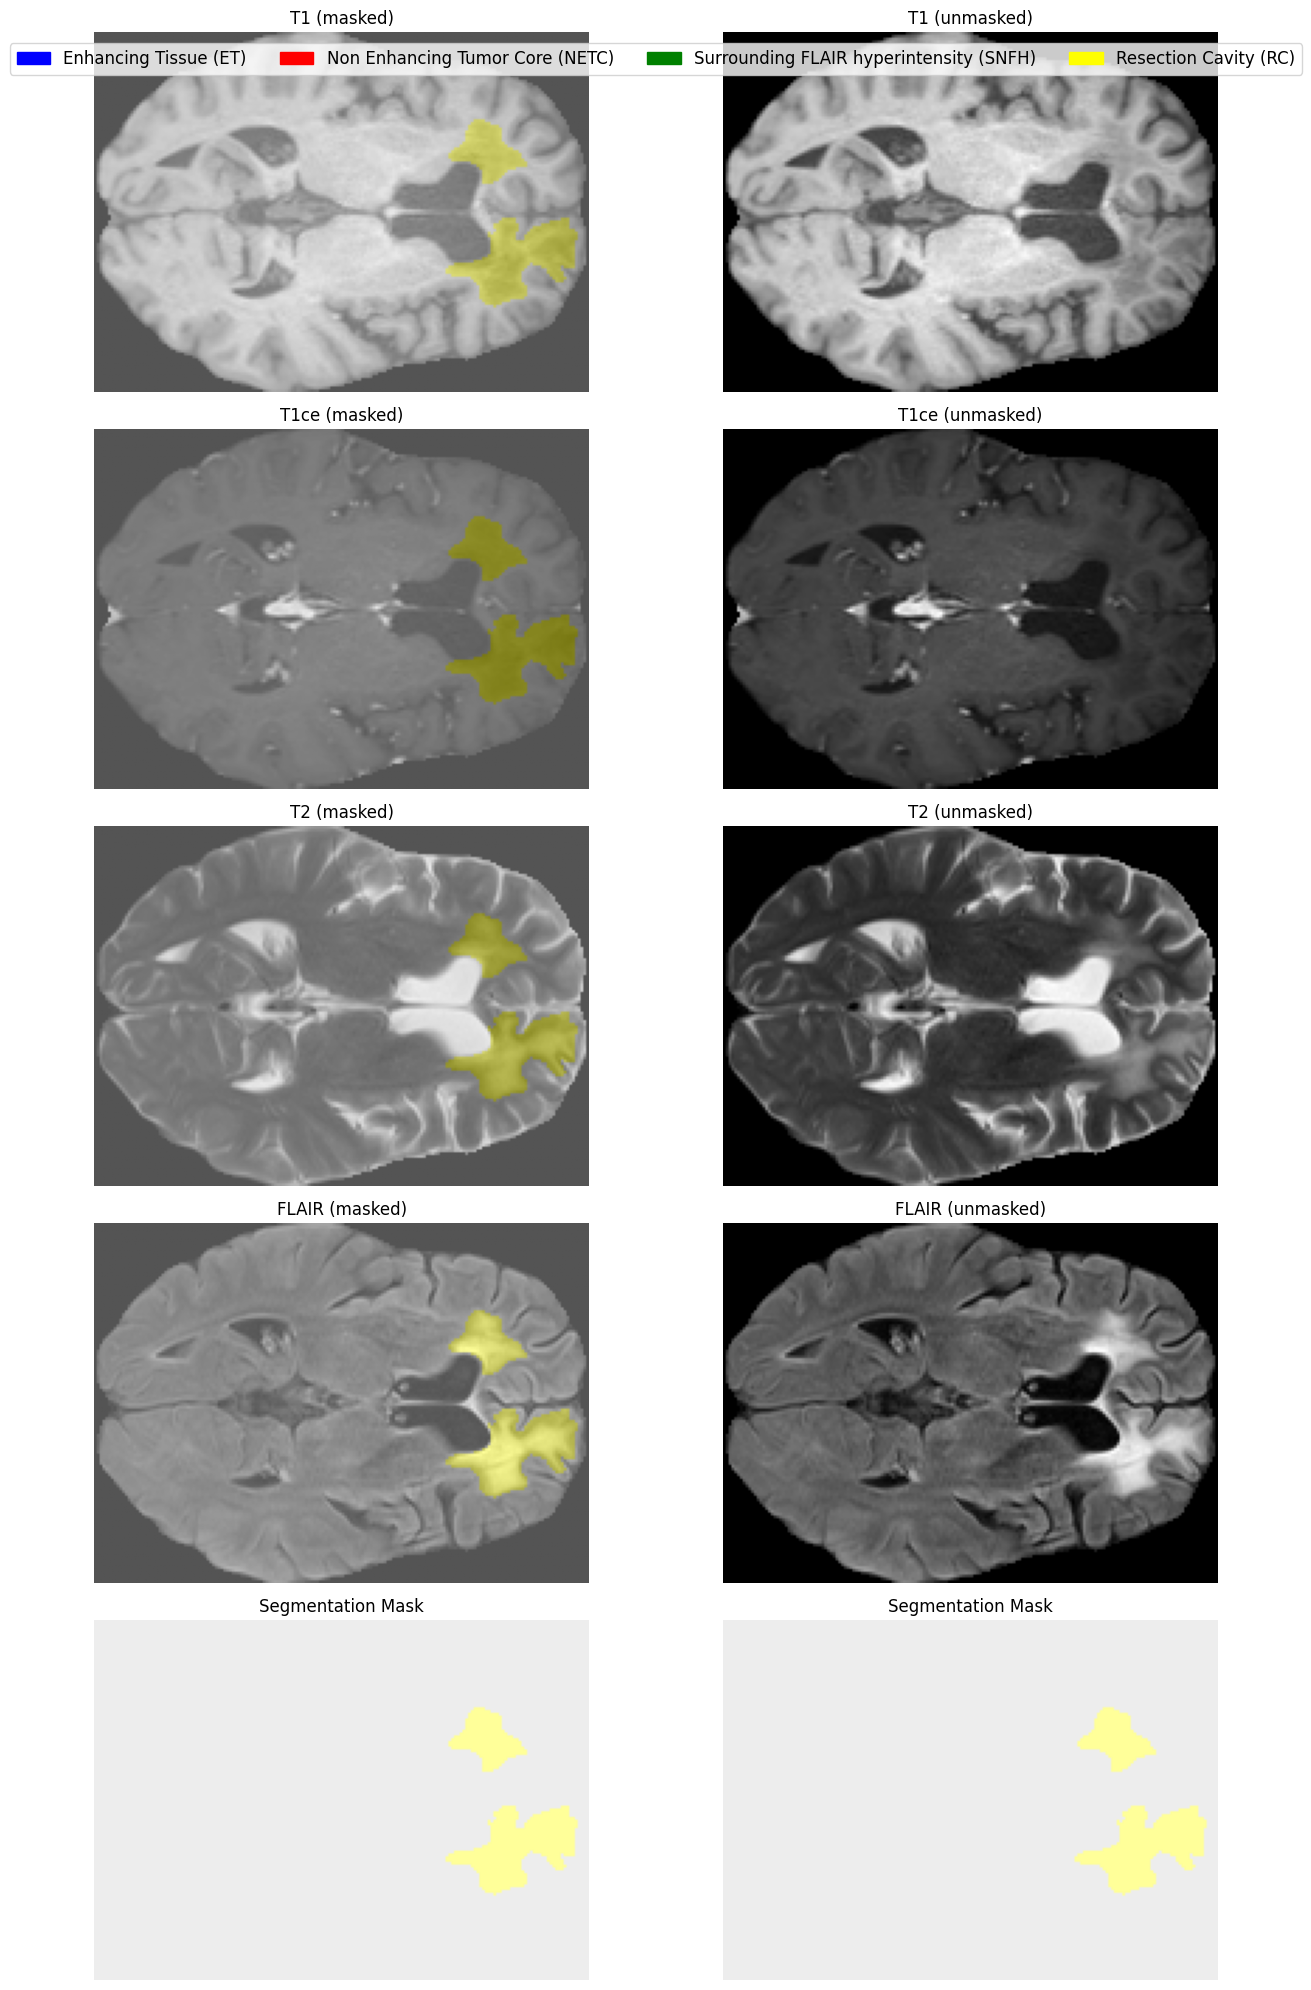

In [9]:
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.patches import Patch

# Modalities
modalities = ['T1', 'T1ce', 'T2', 'FLAIR']

# Select a patient from the batch
test_img = img[0]
test_mask = msk[0]

# Convert one-hot → labels
mask_slice = np.argmax(test_mask[:, :, 64, :], axis=-1)

# Define colors
class_colors = ['blue', 'red', 'green', 'yellow']  # 4 classes
colors_mask = [ 'lightgray','blue', 'red', 'green', 'yellow']
cmap_mask = matplotlib.colors.ListedColormap(colors_mask)

# Class names
class_names = [
    "Enhancing Tissue (ET)",
    "Non Enhancing Tumor Core (NETC)",
    "Surrounding FLAIR hyperintensity (SNFH)",
    "Resection Cavity (RC)"
]

# -----------------------------
# Create figure
# -----------------------------
fig, axs = plt.subplots(5, 2, figsize=(14, 20))  # 4 modalities + mask row, 2 columns

# Plot masked vs unmasked modalities
for i in range(4):
    # Masked
    axs[i, 0].imshow(test_img[:, :, 64, i], cmap='gray')
    axs[i, 0].imshow(mask_slice, cmap=cmap_mask, alpha=0.4)
    axs[i, 0].set_title(f"{modalities[i]} (masked)")
    axs[i, 0].axis('off')
    
    # Unmasked
    axs[i, 1].imshow(test_img[:, :, 64, i], cmap='gray')
    axs[i, 1].set_title(f"{modalities[i]} (unmasked)")
    axs[i, 1].axis('off')

# Mask alone (last row)
for j in range(2):
    axs[4, j].imshow(mask_slice, cmap=cmap_mask, alpha = 0.4)  # vmin=0 for background
    axs[4, j].set_title("Segmentation Mask")
    axs[4, j].axis('off')

# Legend for classes
patches = [Patch(color=class_colors[i], label=class_names[i]) for i in range(len(class_names))]
fig.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 0.98), fontsize=12, ncol=4)

plt.tight_layout()
plt.show()


In [10]:
test_mask.shape

(128, 176, 128, 4)

In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K

# -----------------------------
# Dice Loss for multi-class
# -----------------------------
def dice_loss(y_true, y_pred, smooth=1.0):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[0,1,2,3])
    denominator  = tf.reduce_sum(y_true + y_pred, axis=[0,1,2,3])
    loss = 1 - (2. * intersection + smooth) / (denominator + smooth)
    return tf.reduce_mean(loss)

# -----------------------------
# Categorical Focal Loss
# -----------------------------
def categorical_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))


# -----------------------------
# Combine Dice + Focal Loss
# -----------------------------
def total_loss1(y_true, y_pred):
    return dice_loss(y_true, y_pred) + categorical_focal_loss(y_true, y_pred)


# -----------------------------
# Metrics (you can define more if needed)
# -----------------------------
def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)

    ious = []
    num_classes = tf.reduce_max(y_true) + 1

    for c in tf.range(num_classes):
        y_true_c = tf.cast(tf.equal(y_true, c), tf.float32)
        y_pred_c = tf.cast(tf.equal(y_pred, c), tf.float32)

        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - intersection

        iou = (intersection + smooth) / (union + smooth)
        ious.append(iou)

    return tf.reduce_mean(ious)


# -----------------------------
# Optimizer
# -----------------------------
LR = 5e-5
optim = tf.keras.optimizers.Adam(LR)

In [12]:
import keras.backend as K
import tensorflow as tf
from tensorflow.keras import backend as K



# dice loss as defined above for 4 classes
@tf.function
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    class_num = tf.shape(y_true)[-1]
    dice = 0.0

    for i in tf.range(class_num):
        y_true_f = tf.reshape(y_true[..., i], [-1])
        y_pred_f = tf.reshape(y_pred[..., i], [-1])

        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        dice += (2. * intersection + smooth) / (
            tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
        )

    return dice / tf.cast(class_num, tf.float32)




 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,1] * y_pred[:,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,2] * y_pred[:,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,3] * y_pred[:,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,:,3])) + epsilon)



#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss
def dice_coef_whole(y_true, y_pred, epsilon=1e-6):
    class_num = 3
    i=1
    total_loss=0
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss= ((2. * intersection) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + epsilon))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        total_loss = total_loss + loss
            
    total_loss2 = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss2



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())




import numpy as np
import tensorflow as tf
from keras.metrics import MeanIoU

n_classes = 4

def per_class_iou(y_true, y_pred, n_classes):
 
    metric = MeanIoU(num_classes=n_classes)
    metric.update_state(y_true, y_pred)

    cm = metric.total_cm.numpy()  # confusion matrix (C x C)

    iou_per_class = []
    for i in range(n_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        denom = TP + FP + FN

        iou = TP / denom if denom != 0 else np.nan
        iou_per_class.append(iou)

    return iou_per_class




def dice_per_class(y_true, y_pred, smooth=1e-6):
    """
    y_true, y_pred: (B, H, W, D, C)
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    dice_scores = []
    num_classes = y_true.shape[-1]

    for c in range(num_classes):
        y_true_c = K.flatten(y_true[..., c])
        y_pred_c = K.flatten(y_pred[..., c])

        intersection = K.sum(y_true_c * y_pred_c)
        dice = (2. * intersection + smooth) / (
            K.sum(y_true_c) + K.sum(y_pred_c) + smooth
        )

        dice_scores.append(dice)

    return dice_scores





In [13]:
X_debug, Y_debug = next(train_img_datagen)

print("X shape:", X_debug.shape)
print("Y shape:", Y_debug.shape)


X shape: (2, 128, 176, 128, 4)
Y shape: (2, 128, 176, 128, 4)


In [14]:
import os
import glob
import tensorflow as tf
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# ===============================
# USER-DEFINED VARIABLES (EXISTING)
# ===============================
LR = 0.001
batch_size = batch_size  # already defined in your notebook
train_patient_list = train_patient_list
val_patient_list = val_patient_list
train_img_datagen = train_img_datagen
val_img_datagen = val_img_datagen

# Custom loss & metrics must already be defined
# total_loss1
# dice_coef
# simple_unet_model

# ===============================
# OPTIMIZER
# ===============================
optim = Adam(learning_rate=LR)

# ===============================
# CALLBACKS DIRECTORY
# ===============================
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ===============================
# MODEL CHECKPOINT (SAVE EVERY EPOCH)
# ===============================
checkpoint = ModelCheckpoint(
    filepath=os.path.join(
        CHECKPOINT_DIR,
        "3D-UNet-epoch-{epoch:03d}.keras"
    ),
    verbose=1,
    save_best_only=False,       # IMPORTANT
    save_weights_only=False
)

csv_logger = CSVLogger("training_2021_3Dcca_UNet.log", append=True)

# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True,
#     verbose=1
# )


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          # Reduce LR by half
    patience=10,          # Wait 5 epochs
    verbose=1,
    min_lr=1e-6
)


# ===============================
# STEPS
# ===============================
steps_per_epoch = len(train_patient_list) // batch_size
val_steps_per_epoch = len(val_patient_list) // batch_size

# ===============================
# BUILD OR LOAD MODEL
# ===============================
checkpoint_files = glob.glob(os.path.join(CHECKPOINT_DIR, "3D-UNet-epoch-*.keras"))
initial_epoch = 0

if checkpoint_files:
    
    # Extract epoch numbers from filenames
    def extract_epoch(filepath):
        filename = os.path.basename(filepath)
        return int(filename.split("-")[-1].split(".")[0])
    
    # Pick checkpoint with highest epoch number
    latest_checkpoint = max(checkpoint_files, key=extract_epoch)
    
    print("🔁 Resuming from:", latest_checkpoint)

    initial_epoch = extract_epoch(latest_checkpoint)

    model = tf.keras.models.load_model(
        latest_checkpoint,
        custom_objects={
            "instance_normalization": instance_normalization,
            "total_loss1": total_loss1,
            "dice_coef": dice_coef
        },
        compile=False,
        safe_mode=False
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss=total_loss1,
        metrics=[
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=4),
            dice_coef
        ]
    )

    print("✅ Resuming from epoch:", initial_epoch)

else:
    print("🚀 Starting training from scratch")

    model = simple_unet_model(
        IMG_HEIGHT=128,
        IMG_WIDTH=176,
        IMG_DEPTH=128,
        IMG_CHANNELS=4,
        num_classes=4
    )

    model.compile(
        optimizer=optim,
        loss=total_loss1,
        metrics=[
            'accuracy',
            tf.keras.metrics.MeanIoU(num_classes=4),
            dice_coef
        ]
    )


# ===============================
# MODEL INFO
# ===============================
print(model.input_shape)
print(model.output_shape)

# ===============================
# TRAINING (RESUMABLE)
# ===============================
history = model.fit(
    train_img_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    initial_epoch=initial_epoch,   # 🔥 KEY LINE
    verbose=1,
    validation_data=val_img_datagen,
    validation_steps=val_steps_per_epoch,
    callbacks=[checkpoint, csv_logger, reduce_lr]
)

# ===============================
# FINAL SAVE
# ===============================
model.save("brats_3d_cca_final.keras")


🚀 Starting training from scratch


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 176,  │          0 │ -                 │
│ (InputLayer)        │ 128, 4)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 176,  │      1,744 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 128, 176,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 176,  │      6,928 │ lambda_9[0][0]    │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 88,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 88,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64, 88,    │          0 │ conv3d_21[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 64, 88,    │          0 │ dropout_8[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 88,    │     27,680 │ lambda_10[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 44,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 44,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32, 44,    │          0 │ conv3d_23[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 32, 44,    │          0 │ dropout_9[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 44,    │    110,656 │ lambda_11[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 22,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 22,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 16, 22,    │          0 │ conv3d_25[0][0] 

 Total params: 5,646,260 (21.54 MB)

 Trainable params: 5,646,260 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 176, 128, 4)
(None, 128, 176, 128, 4)
Epoch 1/100


I0000 00:00:1770997272.414788      65 service.cc:152] XLA service 0x7846d0005690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770997272.414829      65 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770997273.850256      65 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-13 15:41:15.848623: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 15:41:16.099110: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 15:41:16.689522: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accur

 49/104 ━━━━━━━━━━━━━━━━━━━━ 5:29 6s/step - accuracy: 0.7528 - dice_coef: 0.2294 - loss: 0.8820 - mean_io_u: 0.3750Skipping BraTS-GLI-00556-100 due to missing files.
 50/104 ━━━━━━━━━━━━━━━━━━━━ 5:22 6s/step - accuracy: 0.7559 - dice_coef: 0.2310 - loss: 0.8790 - mean_io_u: 0.3750

2026-02-13 15:47:00.761028: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 15:47:00.987273: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 15:47:01.403455: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 15:47:01.636633: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 15:47:03.454714: E external/local_xla/xla/stream_

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8470 - dice_coef: 0.2998 - loss: 0.7720 - mean_io_u: 0.3750

2026-02-13 15:53:09.927680: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 15:53:10.179350: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 15:53:10.770780: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 15:53:11.044328: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 15:53:12.086115: E external/local_xla/xla/service


Epoch 1: saving model to checkpoints/3D-UNet-epoch-001.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 881s 8s/step - accuracy: 0.8479 - dice_coef: 0.3008 - loss: 0.7706 - mean_io_u: 0.3750 - val_accuracy: 0.9832 - val_dice_coef: 0.5492 - val_loss: 0.4719 - val_mean_io_u: 0.3758 - learning_rate: 0.0010
Epoch 2/100
 32/104 ━━━━━━━━━━━━━━━━━━━━ 4:12 4s/step - accuracy: 0.9873 - dice_coef: 0.5829 - loss: 0.4318 - mean_io_u: 0.3752Skipping BraTS-GLI-00556-100 due to missing files.
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9866 - dice_coef: 0.5781 - loss: 0.4374 - mean_io_u: 0.3756
Epoch 2: saving model to checkpoints/3D-UNet-epoch-002.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 516s 5s/step - accuracy: 0.9866 - dice_coef: 0.5781 - loss: 0.4373 - mean_io_u: 0.3757 - val_accuracy: 0.9850 - val_dice_coef: 0.5757 - val_loss: 0.4451 - val_mean_io_u: 0.3842 - learning_rate: 0.0010
Epoch 3/100
 20/104 ━━━━━━━━━━━━━━━━━━━━ 3:32 3s/step - accuracy: 0.9862 - dice_coef: 0.5823 - loss: 0.4336 - mean_io_u: 0.37

2026-02-13 16:18:39.592964: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 16:18:39.818173: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 16:18:40.236298: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 16:18:40.468499: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 16:18:42.252343: E external/local_xla/xla/stream_

Skipping BraTS-GLI-00556-100 due to missing files.

Epoch 4: saving model to checkpoints/3D-UNet-epoch-004.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 454s 4s/step - accuracy: 0.9887 - dice_coef: 0.6365 - loss: 0.3773 - mean_io_u: 0.3813 - val_accuracy: 0.9880 - val_dice_coef: 0.6365 - val_loss: 0.3826 - val_mean_io_u: 0.3844 - learning_rate: 0.0010
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9906 - dice_coef: 0.6499 - loss: 0.3603 - mean_io_u: 0.3785Skipping BraTS-GLI-00556-100 due to missing files.

Epoch 5: saving model to checkpoints/3D-UNet-epoch-005.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 385s 4s/step - accuracy: 0.9906 - dice_coef: 0.6499 - loss: 0.3602 - mean_io_u: 0.3785 - val_accuracy: 0.9904 - val_dice_coef: 0.6487 - val_loss: 0.3682 - val_mean_io_u: 0.3960 - learning_rate: 0.0010
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9878 - dice_coef: 0.6338 - loss: 0.3837 - mean_io_u: 0.3825
Epoch 6: saving model to checkpoints/3D-UNet-epoch-006.keras
10

In [15]:
import pandas as pd
history = pd.read_csv('training_2021_3Dcca_UNet.log', sep=',', engine='python')
print(history.columns)


Index(['epoch', 'accuracy', 'dice_coef', 'loss', 'mean_io_u', 'val_accuracy',
       'val_dice_coef', 'val_loss', 'val_mean_io_u'],
      dtype='object')


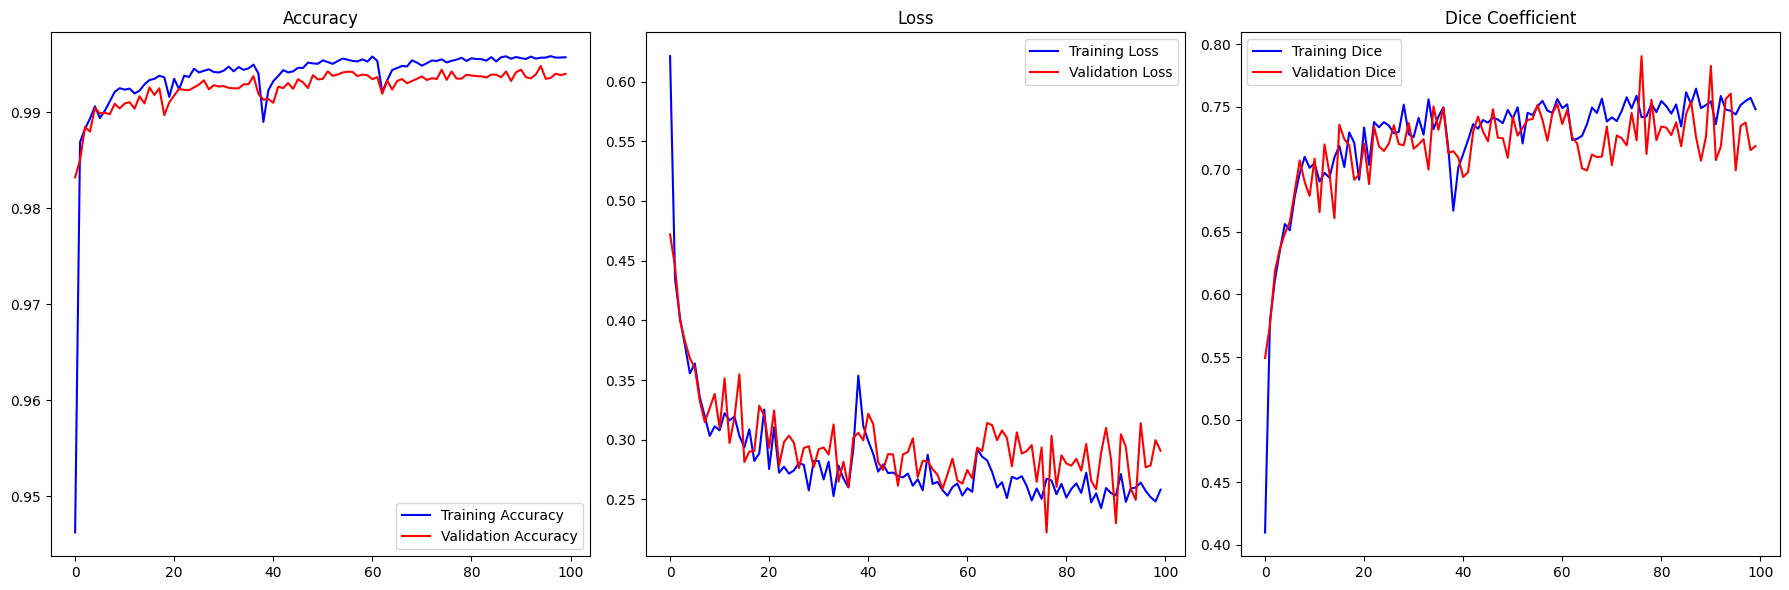

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Minimal InstanceNormalization function
def instance_normalization(x, epsilon=1e-5):
    # Compute mean and variance per instance (per sample, per channel)
    mean, var = tf.nn.moments(x, axes=[1,2,3], keepdims=True)
    return (x - mean) / tf.sqrt(var + epsilon)


# Load model (custom metrics only)
model = tf.keras.models.load_model(
    '/kaggle/working/brats_3d_cca_final.keras',
    custom_objects={
        "dice_coef": dice_coef,
        "dice_coef_whole": dice_coef_whole,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "dice_coef_necrotic": dice_coef_necrotic,
        "dice_coef_edema": dice_coef_edema,
        "dice_coef_enhancing": dice_coef_enhancing,
        "instance_normalization": instance_normalization  # <-- our function
    },
    compile=False
)


# Load training log
history = pd.read_csv('training_2021_3Dcca_UNet.log', sep=',', engine='python')
hist = history

# Extract columns
epoch = range(len(hist))
acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']
train_dice = hist['dice_coef']
val_dice = hist['val_dice_coef']

# Plot
f, ax = plt.subplots(1, 3, figsize=(18, 6))

# Accuracy
ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()
ax[1].set_title('Loss')

# Dice coefficient
ax[2].plot(epoch, train_dice, 'b', label='Training Dice')
ax[2].plot(epoch, val_dice, 'r', label='Validation Dice')
ax[2].legend()
ax[2].set_title('Dice Coefficient')

plt.tight_layout()
plt.savefig('training_result_2026_cca.png')
plt.show()


In [17]:
#Evaluation on (128,128,128)

from keras.metrics import MeanIoU
import numpy as np

batch_size = 1  # keep small if 3D volumes are large

# Validation generator
test_img_datagen = imageLoader(
    root_dir=root_dir,
    patient_list=val_patient_list,
    batch_size=batch_size
)

#train generator
train_img_datagen = imageLoader(
    root_dir=root_dir,
    patient_list=train_patient_list,
    batch_size=batch_size
)


# Get batch of test 
test_image_batch, test_mask_batch = test_img_datagen.__next__()

#Get batch of train
train_image_batch, train_mask_batch = train_img_datagen.__next__()


# Convert one-hot masks to class labels
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
train_mask_batch_argmax = np.argmax(train_mask_batch, axis=4)

# Predict on test
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

# Predict on train
train_pred_batch = model.predict(train_image_batch)
train_pred_batch_argmax = np.argmax(train_pred_batch, axis=4)

# Compute Mean IoU on test data
n_classes = 4
IOU_keras_test = MeanIoU(num_classes=n_classes)
IOU_keras_test.update_state(test_mask_batch_argmax, test_pred_batch_argmax)

# Compute Mean IoU on train data
IOU_keras_train = MeanIoU(num_classes=n_classes)
IOU_keras_train.update_state(train_mask_batch_argmax, train_pred_batch_argmax)

#Compute Dice coefficient for test data
dice_test = dice_coef(test_mask_batch, test_pred_batch)

#Compute Dice coefficient for train data
dice_train = dice_coef(train_mask_batch, train_pred_batch)

print("----Test Data Evaluation on (128,128,128)-----")

print("Mean IoU:", IOU_keras_test.result().numpy())
print("Dice Coefficient: ",dice_test.numpy())

print("----Train Data Evaluation on (128,128,128)-----")

print("Mean IoU: ", IOU_keras_train.result().numpy())
print("Dice Coefficient: ",dice_train.numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
----Test Data Evaluation on (128,128,128)-----
Mean IoU: 0.62462556
Dice Coefficient:  0.67454976
----Train Data Evaluation on (128,128,128)-----
Mean IoU:  0.6356596
Dice Coefficient:  0.68487763


In [18]:
#Per Class evaluation

#-----Iou on each cass-----#

#iou on test data batch
iou_test_per_class = per_class_iou(
    test_mask_batch_argmax,
    test_pred_batch_argmax,
    n_classes
)

# iou on train data batch
iou_train_per_class = per_class_iou(
    train_mask_batch_argmax,
    train_pred_batch_argmax,
    n_classes
)

#show the results 
print("Results of IoU")
for c in range(n_classes):
    print(f"Test IoU - Class {class_names[c]}: {iou_test_per_class[c]:.4f}")
    print(f"Train IoU - Class {class_names[c]}: {iou_train_per_class[c]:.4f}")



#----Dice coefficient of each class----#


#dice coefficient on test data batch
dice_test_per_class = dice_per_class(test_mask_batch, test_pred_batch)

#dice coefficient on train data batch
dice_train_per_class = dice_per_class(train_mask_batch, train_pred_batch)

#show the results
print("Results of Dice")
for c in range(n_classes):
    print(f"Test Dice - Class {class_names[c]}: {dice_test_per_class[c].numpy():.4f}")
    print(f"Train Dice - Class {class_names[c]}: {dice_train_per_class[c].numpy():.4f}")



Results of IoU
Test IoU - Class Enhancing Tissue (ET): 0.9962
Train IoU - Class Enhancing Tissue (ET): 0.9984
Test IoU - Class Non Enhancing Tumor Core (NETC): 0.0000
Train IoU - Class Non Enhancing Tumor Core (NETC): 0.0000
Test IoU - Class Surrounding FLAIR hyperintensity (SNFH): 0.8913
Train IoU - Class Surrounding FLAIR hyperintensity (SNFH): 0.7663
Test IoU - Class Resection Cavity (RC): 0.6111
Train IoU - Class Resection Cavity (RC): 0.7780
Results of Dice
Test Dice - Class Enhancing Tissue (ET): 0.9980
Train Dice - Class Enhancing Tissue (ET): 0.9992
Test Dice - Class Non Enhancing Tumor Core (NETC): 0.0000
Train Dice - Class Non Enhancing Tumor Core (NETC): 0.0000
Test Dice - Class Surrounding FLAIR hyperintensity (SNFH): 0.9394
Train Dice - Class Surrounding FLAIR hyperintensity (SNFH): 0.8643
Test Dice - Class Resection Cavity (RC): 0.7577
Train Dice - Class Resection Cavity (RC): 0.8738


In [19]:
# -----------------------------
# Pick an image from the batch (here batch_size=1, so index 0)
# -----------------------------
test_img = np.expand_dims(test_image_batch[0], axis=0)  # shape: 1,H,W,D,4
test_mask = test_mask_batch[0]                                  # shape: H,W,D,4

# -----------------------------
# Model prediction
# -----------------------------
test_prediction = model.predict(test_img)                 # shape: 1,H,W,D,4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


In [20]:
print("Test mask shape: ", test_mask.shape)
print("Test image shape: ", test_img.shape)
print("Test Prediction shape: ", test_prediction[0].shape)

Test mask shape:  (128, 176, 128, 4)
Test image shape:  (1, 128, 176, 128, 4)
Test Prediction shape:  (128, 176, 128, 4)


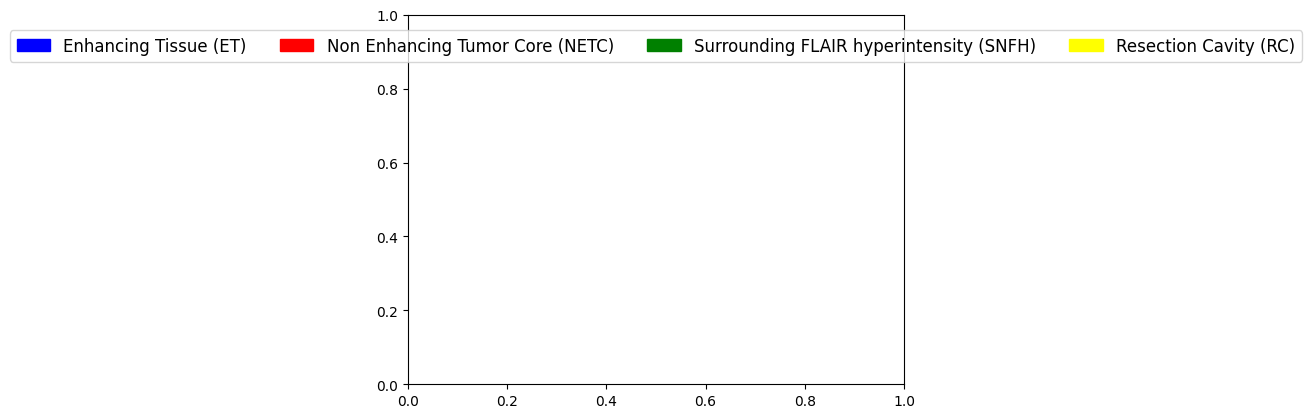

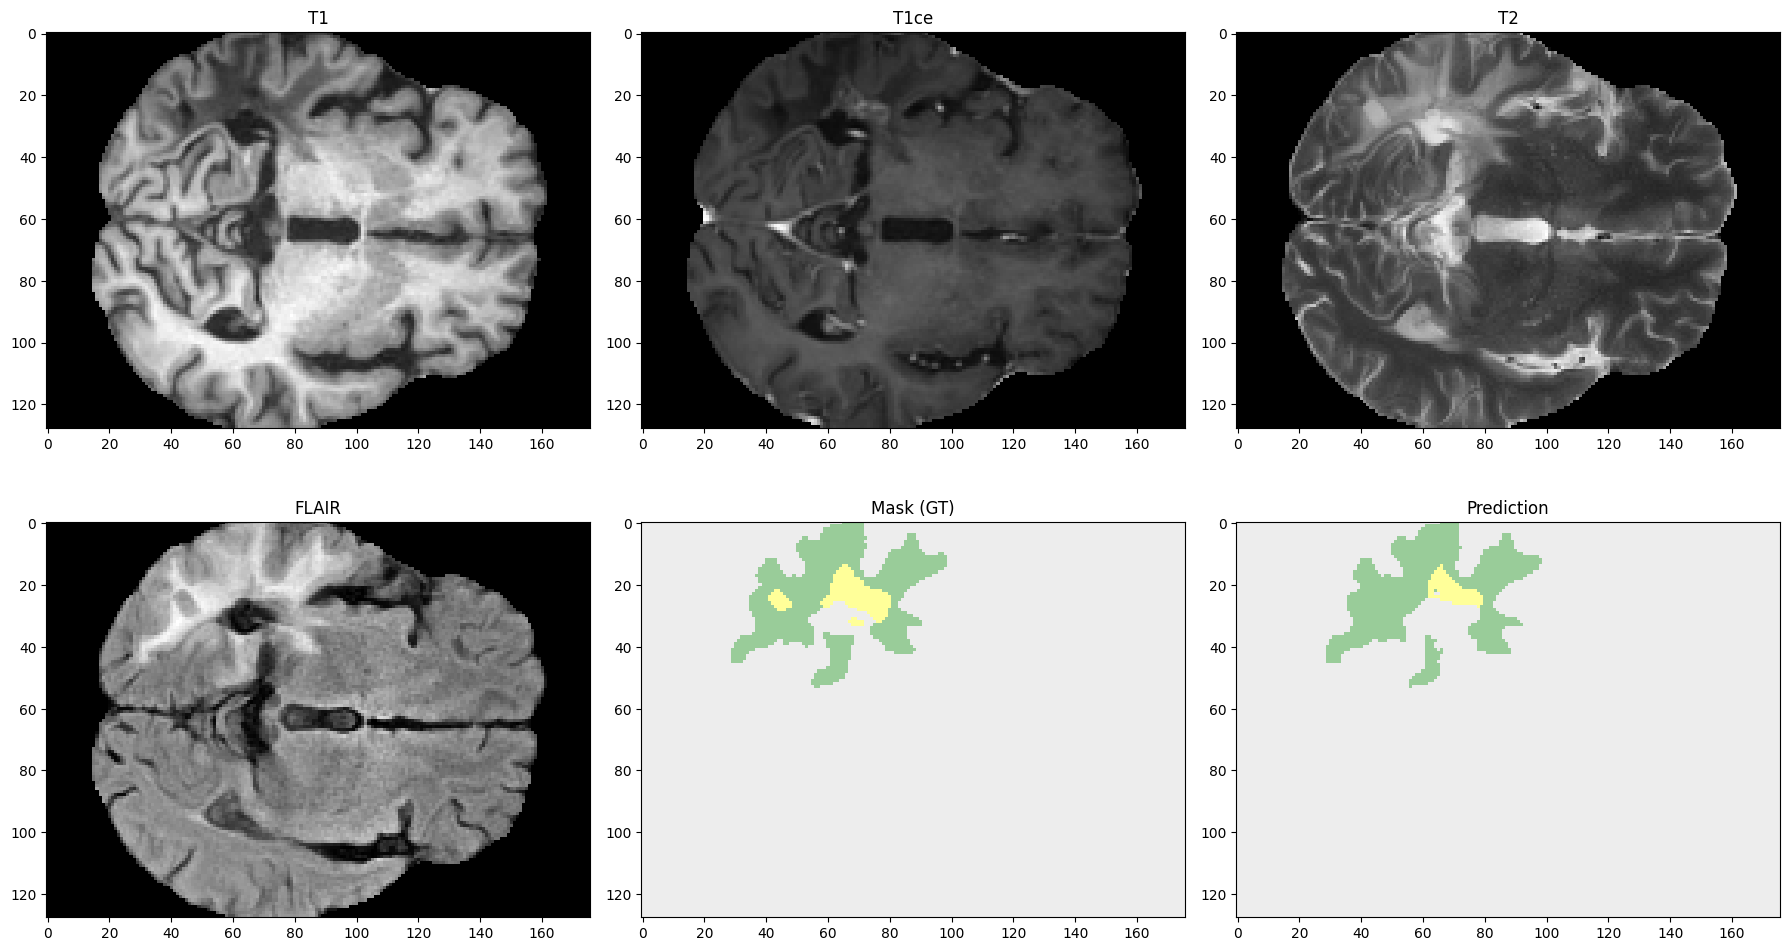

In [21]:
import matplotlib.pyplot as plt


test_img_4mod = test_image_batch[0]   # shape: H, W, D, 4
test_mask_4mod = test_mask            # shape: H, W, D, 4 or one-hot
prediction = test_prediction[0]

# Legend for classes
patches = [Patch(color=class_colors[i], label=class_names[i]) for i in range(len(class_names))]
plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 0.98), fontsize=12, ncol=4)

plt.figure(figsize=(18, 10))

# ---- Modality 1: T1 ----
plt.subplot(2,3,1)
plt.imshow(test_img_4mod[:,:,64,0], cmap='gray')
plt.title('T1')

# ---- Modality 2: T1ce ----
plt.subplot(2,3,2)
plt.imshow(test_img_4mod[:,:,64,1], cmap='gray')
plt.title('T1ce')

# ---- Modality 3: T2 ----
plt.subplot(2,3,3)
plt.imshow(test_img_4mod[:,:,64,2], cmap='gray')
plt.title('T2')

# ---- Modality 4: FLAIR ----
plt.subplot(2,3,4)
plt.imshow(test_img_4mod[:,:,64,3], cmap='gray')
plt.title('FLAIR')

# ---- Ground truth mask ----
plt.subplot(2,3,5)
plt.imshow(np.argmax(test_mask_4mod[:,:,64,:], axis=2), cmap = cmap_mask, alpha = 0.4)
plt.title('Mask (GT)')

# ---- Prediction ----
plt.subplot(2,3,6)
plt.imshow(np.argmax(prediction[:,:,64, :], axis = 2), cmap = cmap_mask, alpha = 0.4)
plt.title('Prediction')


plt.tight_layout()
plt.show()
